Problem statement

Your client is an Insurance company and they need your help in building a model to predict the propensity to pay renewal premium and build an incentive plan for its agents to maximise the net revenue (i.e. renewals - incentives given to collect the renewals) collected from the policies post their issuance.

You have information about past transactions from the policy holders along with their demographics. The client has provided aggregated historical transactional data like number of premiums delayed by 3/ 6/ 12 months across all the products, number of premiums paid, customer sourcing channel and customer demographics like age, monthly income and area type.

In addition to the information above, the client has provided the following relationships:

Expected effort in hours put in by an agent for incentives provided; and
Expected increase in chances of renewal, given the effort from the agent.
 
Given the information, the client wants you to predict the propensity of renewal collection and create an incentive plan for agents (at policy level) to maximise the net revenues from these policies.



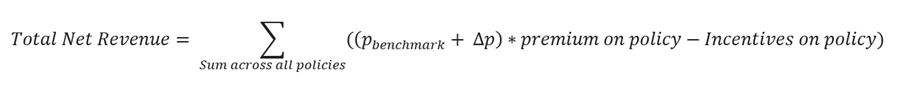

Equation for the effort-incentives curve: Y = 10\*(1-exp(-X/400))

Equation for the % improvement in renewal prob vs effort curve: Y = 20\*(1-exp(-X/5))

Import libraries

In [181]:
import pandas as pd
import numpy as np

Load and read files

In [182]:
# load datasets
train = pd.read_csv('/content/drive/MyDrive/ins_train.csv')
test = pd.read_csv('/content/drive/MyDrive/ins_test.csv')
sample = pd.read_csv('/content/drive/MyDrive/ins_sample.csv')

In [183]:
train

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal
0,110936,0.429,12058,355060,0.0,0.0,0.0,99.02,13,C,Urban,3300,1
1,41492,0.010,21546,315150,0.0,0.0,0.0,99.89,21,A,Urban,18000,1
2,31300,0.917,17531,84140,2.0,3.0,1.0,98.69,7,C,Rural,3300,0
3,19415,0.049,15341,250510,0.0,0.0,0.0,99.57,9,A,Urban,9600,1
4,99379,0.052,31400,198680,0.0,0.0,0.0,99.87,12,B,Urban,9600,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79848,48057,0.425,23367,224550,1.0,0.0,0.0,98.70,19,B,Urban,13800,1
79849,59012,0.704,19356,279150,1.0,0.0,1.0,99.42,12,A,Rural,28500,1
79850,77050,0.000,23372,305020,0.0,0.0,0.0,98.89,12,A,Rural,9600,1
79851,67225,0.398,22641,39330,0.0,0.0,0.0,98.68,8,A,Rural,5700,1


In [184]:
test

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium
0,649,0.001,27384,51150,0.0,0.0,0.0,99.89,7,A,Rural,3300
1,81136,0.124,23735,285140,0.0,0.0,0.0,98.93,19,A,Urban,11700
2,70762,1.000,17170,186030,0.0,0.0,0.0,NaN,2,B,Urban,11700
3,53935,0.198,16068,123540,0.0,0.0,0.0,99.00,11,B,Rural,5400
4,15476,0.041,10591,200020,1.0,0.0,0.0,99.17,14,A,Rural,9600
...,...,...,...,...,...,...,...,...,...,...,...,...
34219,81988,0.227,20810,110240,0.0,0.0,0.0,97.52,9,A,Urban,5400
34220,30326,0.157,19353,125090,0.0,0.0,0.0,99.62,7,A,Rural,1200
34221,65749,0.325,18264,196570,0.0,0.0,0.0,98.58,14,B,Rural,1200
34222,65686,0.983,16798,212150,1.0,0.0,1.0,98.88,10,A,Urban,13800


In [185]:
sample

,id,renewal,incentives
0,649,0.5,1650
1,81136,0.5,1650
2,70762,0.5,1650
3,53935,0.5,1650
4,15476,0.5,1650
...,...,...,...
34219,81988,0.5,1650
34220,30326,0.5,1650
34221,65749,0.5,1650
34222,65686,0.5,1650


In [186]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79853 entries, 0 to 79852
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                79853 non-null  int64  
 1   perc_premium_paid_by_cash_credit  79853 non-null  float64
 2   age_in_days                       79853 non-null  int64  
 3   Income                            79853 non-null  int64  
 4   Count_3-6_months_late             79756 non-null  float64
 5   Count_6-12_months_late            79756 non-null  float64
 6   Count_more_than_12_months_late    79756 non-null  float64
 7   application_underwriting_score    76879 non-null  float64
 8   no_of_premiums_paid               79853 non-null  int64  
 9   sourcing_channel                  79853 non-null  object 
 10  residence_area_type               79853 non-null  object 
 11  premium                           79853 non-null  int64  
 12  rene

In [187]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34224 entries, 0 to 34223
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                34224 non-null  int64  
 1   perc_premium_paid_by_cash_credit  34224 non-null  float64
 2   age_in_days                       34224 non-null  int64  
 3   Income                            34224 non-null  int64  
 4   Count_3-6_months_late             34193 non-null  float64
 5   Count_6-12_months_late            34193 non-null  float64
 6   Count_more_than_12_months_late    34193 non-null  float64
 7   application_underwriting_score    32901 non-null  float64
 8   no_of_premiums_paid               34224 non-null  int64  
 9   sourcing_channel                  34224 non-null  object 
 10  residence_area_type               34224 non-null  object 
 11  premium                           34224 non-null  int64  
dtypes: f

Check for null values

In [188]:
train.isnull().sum()

id                                     0
perc_premium_paid_by_cash_credit       0
age_in_days                            0
Income                                 0
Count_3-6_months_late                 97
Count_6-12_months_late                97
Count_more_than_12_months_late        97
application_underwriting_score      2974
no_of_premiums_paid                    0
sourcing_channel                       0
residence_area_type                    0
premium                                0
renewal                                0
dtype: int64

In [189]:
test.isnull().sum()

id                                     0
perc_premium_paid_by_cash_credit       0
age_in_days                            0
Income                                 0
Count_3-6_months_late                 31
Count_6-12_months_late                31
Count_more_than_12_months_late        31
application_underwriting_score      1323
no_of_premiums_paid                    0
sourcing_channel                       0
residence_area_type                    0
premium                                0
dtype: int64

Impute missing values

In [190]:
train["Count_3-6_months_late"] = train["Count_3-6_months_late"].fillna(train['Count_3-6_months_late'].median())
train["Count_6-12_months_late"] = train["Count_6-12_months_late"].fillna(train['Count_6-12_months_late'].median())
train["Count_more_than_12_months_late"] = train["Count_more_than_12_months_late"].fillna(train['Count_more_than_12_months_late'].median())
train["application_underwriting_score"] = train["application_underwriting_score"].fillna(train['application_underwriting_score'].median())

test["Count_3-6_months_late"] = test["Count_3-6_months_late"].fillna(train['Count_3-6_months_late'].median())
test["Count_6-12_months_late"] = test["Count_6-12_months_late"].fillna(train['Count_6-12_months_late'].median())
test["Count_more_than_12_months_late"] = test["Count_more_than_12_months_late"].fillna(test['Count_more_than_12_months_late'].median())
test["application_underwriting_score"] = test["application_underwriting_score"].fillna(test['application_underwriting_score'].median())

Create new column

In [191]:
train['age_in_years'] = train['age_in_days'] / 365.25
test['age_in_years'] = test['age_in_days'] / 365.25

train['age_in_years'] = train['age_in_years'].astype(int)
test['age_in_years'] = test['age_in_years'].astype(int)

In [192]:
train['incentives'] = train['premium'] * .045
test['incentives'] = test['premium'] * .045

Graph of target variable

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


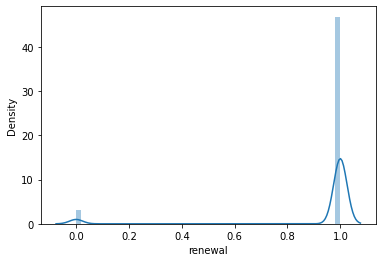

In [193]:
import seaborn as sns

sns.distplot(train['renewal'])

Count target variable

In [194]:
import collections
from collections import Counter

counter = Counter(train.renewal)
for k,v in counter.items():
	per = v / len(train.renewal) * 100
	print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=1, Count=74855, Percentage=93.741%
Class=0, Count=4998, Percentage=6.259%


Graph independant variables

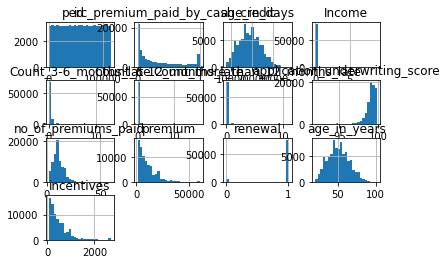

In [195]:
from matplotlib import pyplot as plt

# create a histogram plot of each variable
train.hist(bins=25)
# show the plot
plt.show()

Heatmap

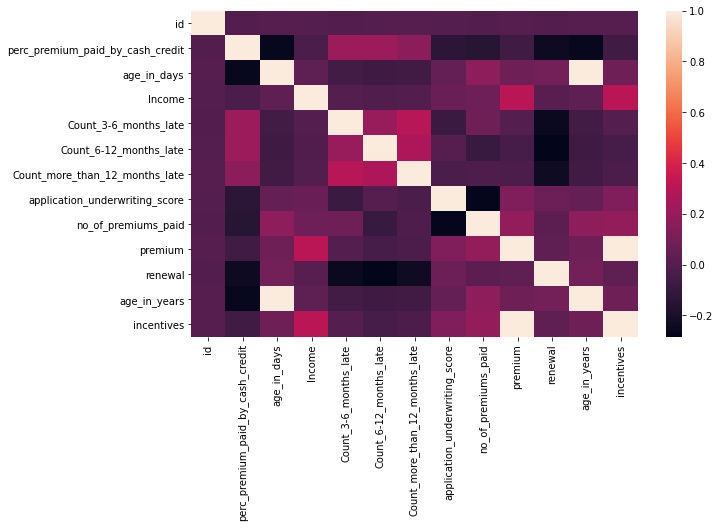

In [196]:
#create a heatmap to correlate promotion
plt.figure(figsize=(10,6))
cmap=train.corr()
sns.heatmap(cmap)

Print off categorial columns

In [197]:
train.dtypes[train.dtypes != 'int64'][train.dtypes != 'float64']

sourcing_channel       object
residence_area_type    object
dtype: object

Ordinal encoder

In [198]:
#ordinal encoder
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()

train.sourcing_channel = enc.fit_transform(train.sourcing_channel.values.reshape(-1,1))
train.residence_area_type = enc.fit_transform(train.residence_area_type.values.reshape(-1,1))

test.sourcing_channel = enc.fit_transform(test.sourcing_channel.values.reshape(-1,1))
test.residence_area_type = enc.fit_transform(test.residence_area_type.values.reshape(-1,1))

In [199]:
train

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal,age_in_years,incentives
0,110936,0.429,12058,355060,0.0,0.0,0.0,99.02,13,2.0,1.0,3300,1,33,148.5
1,41492,0.010,21546,315150,0.0,0.0,0.0,99.89,21,0.0,1.0,18000,1,58,810.0
2,31300,0.917,17531,84140,2.0,3.0,1.0,98.69,7,2.0,0.0,3300,0,47,148.5
3,19415,0.049,15341,250510,0.0,0.0,0.0,99.57,9,0.0,1.0,9600,1,42,432.0
4,99379,0.052,31400,198680,0.0,0.0,0.0,99.87,12,1.0,1.0,9600,1,85,432.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79848,48057,0.425,23367,224550,1.0,0.0,0.0,98.70,19,1.0,1.0,13800,1,63,621.0
79849,59012,0.704,19356,279150,1.0,0.0,1.0,99.42,12,0.0,0.0,28500,1,52,1282.5
79850,77050,0.000,23372,305020,0.0,0.0,0.0,98.89,12,0.0,0.0,9600,1,63,432.0
79851,67225,0.398,22641,39330,0.0,0.0,0.0,98.68,8,0.0,0.0,5700,1,61,256.5


In [200]:
test

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,age_in_years,incentives
0,649,0.001,27384,51150,0.0,0.0,0.0,99.89,7,0.0,0.0,3300,74,148.5
1,81136,0.124,23735,285140,0.0,0.0,0.0,98.93,19,0.0,1.0,11700,64,526.5
2,70762,1.000,17170,186030,0.0,0.0,0.0,99.21,2,1.0,1.0,11700,47,526.5
3,53935,0.198,16068,123540,0.0,0.0,0.0,99.00,11,1.0,0.0,5400,43,243.0
4,15476,0.041,10591,200020,1.0,0.0,0.0,99.17,14,0.0,0.0,9600,28,432.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34219,81988,0.227,20810,110240,0.0,0.0,0.0,97.52,9,0.0,1.0,5400,56,243.0
34220,30326,0.157,19353,125090,0.0,0.0,0.0,99.62,7,0.0,0.0,1200,52,54.0
34221,65749,0.325,18264,196570,0.0,0.0,0.0,98.58,14,1.0,0.0,1200,50,54.0
34222,65686,0.983,16798,212150,1.0,0.0,1.0,98.88,10,0.0,1.0,13800,45,621.0


Define X, y and X_test

In [201]:
train_id = train.id
test_id = test.id

y = train.renewal
X = train.drop(['renewal', 'age_in_days', 'id'], axis = 1)
X_test = test.drop(['age_in_days', 'id'], axis = 1)

Standard Scaler

In [202]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = scaler.fit_transform(X) # normalizing the features
# Scale the test set
X_test = scaler.transform(X_test)
X.shape, X_test.shape

((79853, 12), (34224, 12))

In [203]:
X

array([[ 0.34251415,  0.29443993, -0.35938304, ..., -0.81097826,
        -1.27573452, -0.81097826],
       [-0.90855901,  0.21407012, -0.35938304, ...,  0.75258245,
         0.50614563,  0.75258245],
       [ 1.79961129, -0.25113234,  2.53456277, ..., -0.81097826,
        -0.27788164, -0.81097826],
       ...,
       [-0.93841756,  0.19367056, -0.35938304, ..., -0.14088081,
         0.86252166, -0.14088081],
       [ 0.24995265, -0.34136966, -0.35938304, ..., -0.55570304,
         0.71997125, -0.55570304],
       [ 0.70380258,  0.14356781,  1.08758987, ..., -0.14088081,
        -0.56298246, -0.14088081]])

Graph 2D

In [204]:
np.mean(X),np.std(X)

(7.553255637727145e-16, 0.9999999999999999)

In [205]:
feat_cols = ['feature'+str(i) for i in range(X.shape[1])]
feat_cols

['feature0',
 'feature1',
 'feature2',
 'feature3',
 'feature4',
 'feature5',
 'feature6',
 'feature7',
 'feature8',
 'feature9',
 'feature10',
 'feature11']

In [206]:
normalised = pd.DataFrame(X,columns=feat_cols)
normalised

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11
0,0.342514,0.294440,-0.359383,-0.179012,-0.192199,-0.072421,0.413122,1.118955,0.810732,-0.810978,-1.275735,-0.810978
1,-0.908559,0.214070,-0.359383,-0.179012,-0.192199,1.125282,1.960315,-0.782089,0.810732,0.752582,0.506146,0.752582
2,1.799611,-0.251132,2.534563,6.697811,3.014592,-0.526723,-0.747272,1.118955,-1.233454,-0.810978,-0.277882,-0.810978
3,-0.792111,0.083900,-0.359383,-0.179012,-0.192199,0.684748,-0.360474,-0.782089,0.810732,-0.140881,-0.634258,-0.140881
4,-0.783153,-0.020474,-0.359383,-0.179012,-0.192199,1.097749,0.219723,0.168433,0.810732,-0.140881,2.430576,-0.140881
...,...,...,...,...,...,...,...,...,...,...,...,...
79848,0.330571,0.031622,1.087590,-0.179012,-0.192199,-0.512956,1.573517,0.168433,0.810732,0.305851,0.862522,0.305851
79849,1.163624,0.141574,1.087590,-0.179012,3.014592,0.478247,0.219723,-0.782089,-1.233454,1.869412,0.078494,1.869412
79850,-0.938418,0.193671,-0.359383,-0.179012,-0.192199,-0.251389,0.219723,-0.782089,-1.233454,-0.140881,0.862522,-0.140881
79851,0.249953,-0.341370,-0.359383,-0.179012,-0.192199,-0.540489,-0.553873,-0.782089,-1.233454,-0.555703,0.719971,-0.555703


In [207]:
from sklearn.decomposition import PCA

pca_insurance = PCA(n_components=2)
principalComponents_insurance = pca_insurance.fit_transform(X)

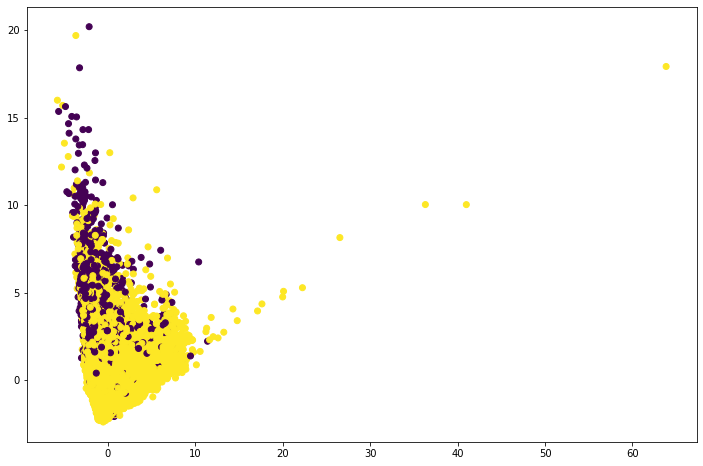

In [208]:
plt.figure(figsize=(12,8))
plt.scatter(principalComponents_insurance[:, 0], principalComponents_insurance[:, 1], c = y, alpha = 1)

In [209]:
pca_insurance = PCA(n_components=12)

Split X dataset

In [210]:
#split train set for testing
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=1, stratify=y, shuffle=True)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((71867, 12), (7986, 12), (71867,), (7986,))

Count values in validation set

In [211]:
from collections import Counter

print(Counter(y_val))

Counter({1: 7486, 0: 500})


Class weights

In [212]:
from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight('balanced',np.unique(y_train), y_train))) 

Define model

In [213]:
from sklearn.svm import LinearSVC

model = LinearSVC(class_weight='balanced', dual=True, max_iter=850, C=20).fit(X_train, y_train)
print(model.score(X_train, y_train))


0.8791935102341826


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [214]:
#print the tunable parameters (They were not tuned in this example, everything kept as default)
params = model.get_params()
print(params)

{'C': 20, 'class_weight': 'balanced', 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 850, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


Prediction on validation set

In [215]:
y_pred = model.predict(X_val)
print(model.score(X_val, y_val))

0.8844227397946406


In [216]:
# confusion matrix 
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred)  
print ("Confusion Matrix : \n", cm)

Confusion Matrix : 
 [[ 181  319]
 [ 604 6882]]


In [217]:
print(Counter(y_val))

Counter({1: 7486, 0: 500})


In [218]:
print(Counter(y_pred))

Counter({1: 7201, 0: 785})


In [219]:
df=pd.DataFrame({'Actual': y_val, 'Predicted':y_pred})
df

,Actual,Predicted
41021,1,1
23814,1,1
30306,1,1
27997,1,1
3701,1,1
...,...,...
613,1,1
15498,1,1
34715,1,1
26722,1,0


Plot errors

In [220]:
pca_val = PCA(n_components=2)
principalComponents_val = pca_val.fit_transform(X_val)

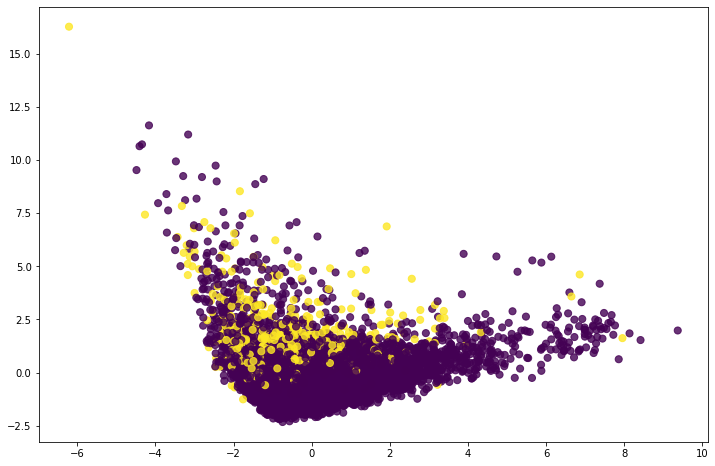

In [221]:
plt.figure(figsize = (12, 8))
plt.scatter(principalComponents_val[:, 0], principalComponents_val[:,1], c = y_pred == y_val - 1, alpha = .8, s = 50)

Predict on test set

In [222]:
predictions = model.predict(X_test)
predictions

array([1, 1, 1, ..., 1, 1, 1])

Prepare incentives

In [223]:
incentives = test['incentives']
incentives

0        148.5
1        526.5
2        526.5
3        243.0
4        432.0
         ...  
34219    243.0
34220     54.0
34221     54.0
34222    621.0
34223    243.0
Name: incentives, Length: 34224, dtype: float64

Prepare submission

In [224]:
output = pd.DataFrame({'id': test_id, 'renewal': predictions, 'incentives': incentives})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


Submit predictions

In [225]:
#upload submission
submission = pd.read_csv("submission.csv")
submission

,id,renewal,incentives
0,649,1,148.5
1,81136,1,526.5
2,70762,1,526.5
3,53935,1,243.0
4,15476,1,432.0
...,...,...,...
34219,81988,1,243.0
34220,30326,1,54.0
34221,65749,1,54.0
34222,65686,1,621.0
